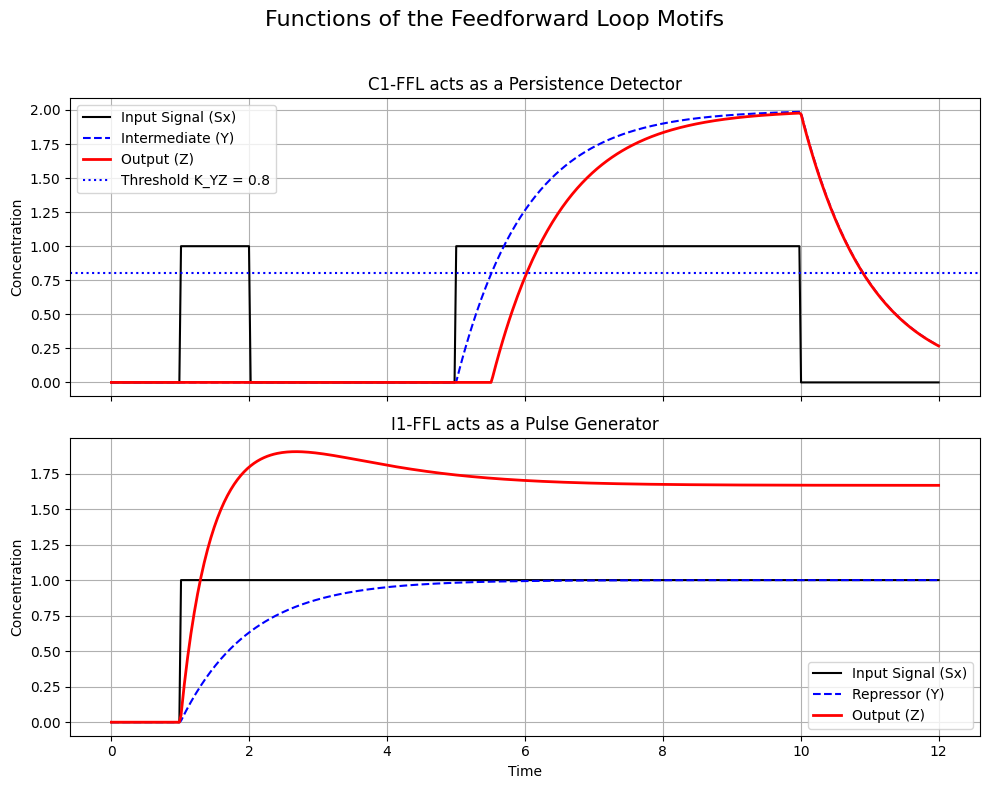

In [1]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# --- Part 1: Define the FFL Model ---

# A general function for the FFL dynamics.
# We'll control which FFL type it is using the parameters.
# vars: a list containing the concentrations [Y, Z]
# t: current time
# params: a dictionary of all parameters
def ffl_model(vars, t, params):
    Y, Z = vars
    X_input = params['X_input_func'](t) # Get the current level of input X

    # --- Dynamics for the intermediate, Y ---
    # Production of Y is activated by X
    # Using a simple logic approximation for activation
    if X_input > params['K_XY']:
        production_Y = params['beta_Y']
    else:
        production_Y = 0

    dYdt = production_Y - params['alpha_Y'] * Y

    # --- Dynamics for the output, Z ---
    # Get the regulation signals from X and Y
    X_reg = 1 if X_input > params['K_XZ'] else 0
    Y_reg_raw = Y / params['K_YZ'] # How much Y relative to its threshold

    # Apply the sign of the Y->Z interaction
    if params['Y_reg_sign'] == '+':
        # Coherent FFL: Y is an activator
        Y_reg = 1 if Y_reg_raw > 1 else 0
    else:
        # Incoherent FFL: Y is a repressor
        # We model this with a simple inverse function for the logic
        production_factor_Y = 1 / (1 + Y_reg_raw) # This is a simple repression model

    # Check the logic gate for Z
    if params['Z_logic_gate'] == 'AND':
        # For C1-FFL: needs both X and Y to be active
        if params['Y_reg_sign'] == '+':
            gate_output = X_reg * Y_reg
        else: # This case is not standard, but for completeness
            gate_output = 0
    elif params['Z_logic_gate'] == 'PULSE': # For I1-FFL
        # Production is activated by X, but repressed by Y
        gate_output = X_reg * production_factor_Y

    production_Z = params['beta_Z'] * gate_output
    dZdt = production_Z - params['alpha_Z'] * Z

    return [dYdt, dZdt]


# --- Part 2: Simulate the C1-FFL (Persistence Detector) ---

# Define the input signal: one short pulse and one long pulse
def input_signal_c1(t):
    if 1 <= t < 2:  # Short pulse
        return 1.0
    if 5 <= t < 10: # Long pulse
        return 1.0
    return 0.0

# Parameters for C1-FFL
params_c1 = {
    'X_input_func': input_signal_c1,
    'beta_Y': 2, 'alpha_Y': 1, 'K_XY': 0.5,
    'beta_Z': 2, 'alpha_Z': 1, 'K_XZ': 0.5, 'K_YZ': 0.8, # K_YZ is the key delay parameter
    'Y_reg_sign': '+',
    'Z_logic_gate': 'AND'
}

# Initial conditions and time
vars0 = [0, 0] # Start with Y=0, Z=0
t_c1 = np.linspace(0, 12, 500)

# Run simulation
solution_c1 = odeint(ffl_model, vars0, t_c1, args=(params_c1,))
Y_c1, Z_c1 = solution_c1.T

# Plot C1-FFL results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig.suptitle('Functions of the Feedforward Loop Motifs', fontsize=16)

ax1.plot(t_c1, [input_signal_c1(ti) for ti in t_c1], 'k-', label='Input Signal (Sx)')
ax1.plot(t_c1, Y_c1, 'b--', label='Intermediate (Y)')
ax1.plot(t_c1, Z_c1, 'r-', linewidth=2, label='Output (Z)')
ax1.axhline(y=params_c1['K_YZ'], color='b', linestyle=':', label=f'Threshold K_YZ = {params_c1["K_YZ"]}')
ax1.set_title('C1-FFL acts as a Persistence Detector')
ax1.set_ylabel('Concentration')
ax1.legend()
ax1.grid(True)


# --- Part 3: Simulate the I1-FFL (Pulse Generator) ---

# Define the input signal: a simple step function
def input_signal_i1(t):
    return 1.0 if t >= 1 else 0.0

# Parameters for I1-FFL
params_i1 = {
    'X_input_func': input_signal_i1,
    'beta_Y': 1, 'alpha_Y': 1, 'K_XY': 0.5, # Y is the repressor
    'beta_Z': 5, 'alpha_Z': 1, 'K_XZ': 0.5, 'K_YZ': 0.5,
    'Y_reg_sign': '-',
    'Z_logic_gate': 'PULSE'
}

t_i1 = np.linspace(0, 12, 500)

# Run simulation
solution_i1 = odeint(ffl_model, vars0, t_i1, args=(params_i1,))
Y_i1, Z_i1 = solution_i1.T

# Plot I1-FFL results
ax2.plot(t_i1, [input_signal_i1(ti) for ti in t_i1], 'k-', label='Input Signal (Sx)')
ax2.plot(t_i1, Y_i1, 'b--', label='Repressor (Y)')
ax2.plot(t_i1, Z_i1, 'r-', linewidth=2, label='Output (Z)')
ax2.set_title('I1-FFL acts as a Pulse Generator')
ax2.set_xlabel('Time')
ax2.set_ylabel('Concentration')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()